## Recommender System - Marketplace Matching

In this notebook, we will: 
- Clean textual data from user-input verbatim posts
- Use a Word2Vec model to calculate document similarities 
- Sort the most similar user input to our training data in order to recommend similar products 
- Save this model in a format that allows us to refresh the testing data

### Data Collection and Preprocessing

In [19]:
#Importing Libraries
import numpy as np
import pandas as pd

import sys
from pandas import DataFrame

import json
from pandas.io.json import json_normalize
import csv

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from gensim import corpora
from collections import defaultdict
from pprint import pprint

from gensim.models.word2vec import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts

import re
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('stopwords') ###

import gensim 
from gensim.models import KeyedVectors
import gensim.downloader as api

from operator import itemgetter, attrgetter

from gensim.models.doc2vec import Doc2Vec

import os, sys

from operator import add

from sklearn.preprocessing import normalize

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from adjustText import adjust_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelateng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Preprocessing and reading the data
allposts = pd.read_csv("allPostData.csv", header=0)
allposts.head()

,archivedStatus,address__components__city,address__components__country,address__components__county,address__components__number,address__components__premise,address__components__state,address__components__street,address__components__zip_code,address__formatted,...,photos__001,photos__002,photos__003,photos__004,post_type,price,price_type,status,title,visibility
0,NaN,Providence,US,Providence County,158,NaN,RI,University Ave,2906.0,"158 University Ave, Providence, RI 02906, USA",...,NaN,NaN,NaN,NaN,request,25.0,flexible,legacy,Teach Me How To Cook!,public
1,NaN,Providence,US,Providence County,157,NaN,RI,University Ave,2906.0,"157 University Ave, Providence, RI 02906, USA",...,NaN,NaN,NaN,NaN,offering,15.0,flexible,legacy,Long Boarding Lessons,public
2,NaN,Providence,US,Providence County,233,NaN,RI,Hope St,2906.0,"233 Hope St, Providence, RI 02906, USA",...,NaN,NaN,NaN,NaN,request,15.0,flexible,legacy,Personal Trainer,public
3,NaN,Providence,US,Providence County,152,NaN,RI,University Ave,2906.0,"152 University Ave, Providence, RI 02906, USA",...,NaN,NaN,NaN,NaN,offering,15.0,flexible,legacy,Final Cut Pro Lesson,public
4,NaN,Providence,US,Providence County,184,Prince Engineering Laboratory,RI,Hope St,2912.0,"Prince Engineering Laboratory, 184 Hope St, Pr...",...,NaN,NaN,NaN,NaN,offering,15.0,set_price,legacy,Resume Building,public


In [4]:
# only select relevant columns --> post titles and descriptions
allposts = allposts[['description', 'title']]
allposts.info()
allposts.shape
allposts[:30]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 2 columns):
description    811 non-null object
title          811 non-null object
dtypes: object(2)
memory usage: 12.8+ KB


,description,title
0,I'm trying to broaden the repertoire of culina...,Teach Me How To Cook!
1,I teach you how to ride. It's an incredibly fu...,Long Boarding Lessons
2,Looking for someone to motivate and guide me i...,Personal Trainer
3,I have 10 years experience editing videos usin...,Final Cut Pro Lesson
4,Let me help you build a resume. I've worked ev...,Resume Building
5,Everyday is an opportunity to do something inc...,Motivational Pep Talk
6,I've completed 400+ job applications over the ...,Resume + Cover Letter
7,"Handmade (by me!) paracord bracelet, similar t...",Paracord Bracelet
8,"I'll help you with shooting, editing, sound mi...",Video Production
9,Interested in consulting or business? Come pra...,Consulting Cases


In [5]:
#take all the post titles
titles = allposts['title']
titles[:10]

#if it is an object, does that mean it's a list of strings?

0     Teach Me How To Cook!
1     Long Boarding Lessons
2          Personal Trainer
3      Final Cut Pro Lesson
4           Resume Building
5     Motivational Pep Talk
6    Resume + Cover Letter 
7         Paracord Bracelet
8         Video Production 
9          Consulting Cases
Name: title, dtype: object

In [6]:
#Create a list of strings comprised of different title names
post_titles = [title for title in titles]
post_titles[:10]

['Teach Me How To Cook!',
 'Long Boarding Lessons',
 'Personal Trainer',
 'Final Cut Pro Lesson',
 'Resume Building',
 'Motivational Pep Talk',
 'Resume + Cover Letter ',
 'Paracord Bracelet',
 'Video Production ',
 'Consulting Cases']

In [7]:
#for each string of post titles in the list, tokenize the string into words
tokens = [[word for word in title.lower().split()] for title in post_titles]
tokens[:10]

[['teach', 'me', 'how', 'to', 'cook!'],
 ['long', 'boarding', 'lessons'],
 ['personal', 'trainer'],
 ['final', 'cut', 'pro', 'lesson'],
 ['resume', 'building'],
 ['motivational', 'pep', 'talk'],
 ['resume', '+', 'cover', 'letter'],
 ['paracord', 'bracelet'],
 ['video', 'production'],
 ['consulting', 'cases']]

In [8]:
#Remove punctuationi and non-alphanumeric tokens including emojis 
clean_words = [[word for word in title if word.isalpha()] for title in tokens]
clean_words[:10]

[['teach', 'me', 'how', 'to'],
 ['long', 'boarding', 'lessons'],
 ['personal', 'trainer'],
 ['final', 'cut', 'pro', 'lesson'],
 ['resume', 'building'],
 ['motivational', 'pep', 'talk'],
 ['resume', 'cover', 'letter'],
 ['paracord', 'bracelet'],
 ['video', 'production'],
 ['consulting', 'cases']]

### Data Cleaning

#### (1) Define a function that takes in a list of strings and cleans it up
First, we need to clean up our text.

In [9]:
#identify a list of stopwords then remove words in stoplist from post titles
stoplist = set(stopwords.words('english'))
titles_nostopwords = [[word for word in title if word not in stoplist] for title in clean_words]
print(stoplist)
#print(titles_nostopwords)
titles_nostopwords[:30]

{'a', 'too', 'we', 'will', 'wasn', 'against', 'why', 'some', "it's", 'can', 'are', 'most', 'ours', 'more', 'they', 'who', 'again', 'not', 't', 'because', "mustn't", 're', "haven't", "you're", 'all', 'don', 'been', 'her', 'further', 'll', 'ma', 'those', 'me', 'which', 'couldn', 'my', 'be', 'now', "isn't", 'shan', 'but', 'there', 'didn', 'haven', 'very', 'how', 'them', "wouldn't", 'during', 'his', 'from', 's', 'doesn', 'aren', 'above', 'once', "hasn't", 'do', 'below', 'themselves', 'over', 'ain', 'was', "aren't", 'you', 'off', 'have', 'so', "you'd", 'having', 'out', 'while', 'just', "doesn't", 'mightn', "couldn't", 'myself', 'same', 'hers', 'before', 'shouldn', 'ourselves', "shan't", 'to', 'about', 'and', 'both', 'on', 'or', 'as', 'doing', "shouldn't", 'hadn', 'at', 'mustn', "mightn't", 'these', 'hasn', 'other', 'after', 'under', 'few', 'being', 'down', 'that', 'yours', 'y', 'himself', 'of', 'no', 'weren', 'here', "hadn't", 'itself', 'did', 'what', 'had', "you'll", 'than', 'should', "she

[['teach'],
 ['long', 'boarding', 'lessons'],
 ['personal', 'trainer'],
 ['final', 'cut', 'pro', 'lesson'],
 ['resume', 'building'],
 ['motivational', 'pep', 'talk'],
 ['resume', 'cover', 'letter'],
 ['paracord', 'bracelet'],
 ['video', 'production'],
 ['consulting', 'cases'],
 ['sas', 'sql', 'tutor'],
 ['video', 'production'],
 ['guitar', 'lessons'],
 ['photography', 'portraits'],
 ['help', 'tinder', 'profile'],
 ['custom', 'love', 'song'],
 ['gym', 'buddy'],
 ['personal', 'cheerleader'],
 ['fan'],
 ['lil', 'ducky'],
 ['snowboarding', 'lessons'],
 ['bed', 'bath', 'beyond', 'drawers'],
 ['math', 'tutor'],
 ['head', 'lamp'],
 ['web', 'development'],
 ['rice', 'cooking', 'pot'],
 ['get', 'startup', 'job'],
 ['tennis', 'racket'],
 ['alarm', 'clock', 'clock'],
 ['orgo', 'kit']]

**"titles_nostopwords"** is now our cleaned up document, containing the data from our users. As seen above, it is still a list of lists--in other words, a nested list of strings, with each string representing a word.

#### (2) Vectorize the document 
Then, we need to take all the titles in the data, and vectorize each word using the large Google trained model which we've just loaded.

The RaRe Technologies (https://github.com/RaRe-Technologies/gensim-data) website describes the dataset as: "Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/)."

In [10]:
#Load pre-trained Word2Vec model based on the Google corpus (https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz)
#import warnings
#warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 


In [11]:
#sanity check 
#model.shape

# Check dimension of word vectors and info about the model
print(model.vector_size)
print(model)

300


The 300 dimensions is significant here because it tells us that the model generates 300-D word vectors. The "Word Vector Dimension" is the dimension of the vector that has been trained by Google using their news data. The industry norm is to use 300-500 D sized vectors because research has shown that there hasn't been significant performance improvement after 300-400, although this depends on the dataset. Note that word vector dimension is NOT the same as the vocabulary size. Some helpful links are the following: (https://stackoverflow.com/questions/38137551/what-is-word-vector-dimension, https://www.youtube.com/watch?v=kGGA1Wm8_x0&feature=youtu.be, https://medium.com/@jayeshbahire/introduction-to-word-vectors-ea1d4e4b84bf) 

For a deeper look into word vectors, an example is shown below: 

In [11]:
food_word_vector = model['food']
print(food_word_vector[:50])
food_word_vector.shape

[-0.18164062  0.16503906 -0.16601562  0.35742188 -0.09228516  0.20117188
 -0.0546875  -0.26171875 -0.17285156 -0.08056641  0.14648438 -0.24609375
  0.18652344  0.10253906 -0.3203125   0.16699219 -0.0032196  -0.06640625
  0.06591797 -0.109375    0.13964844 -0.05029297  0.25390625  0.0859375
  0.02026367  0.05517578 -0.08447266  0.07324219  0.15429688 -0.13867188
 -0.25195312 -0.15136719  0.07958984  0.00848389 -0.24902344  0.05224609
  0.04394531 -0.19726562 -0.2109375   0.01477051 -0.23632812 -0.14355469
  0.17773438  0.26757812 -0.08789062 -0.07910156 -0.16113281  0.23632812
 -0.07177734  0.08837891]


(300,)

Next, we need to create a process to vectorize all the words for each title in our title list. We know that word2vec can only "vectorize" words that show up in the Google News vocabulary, so we need to ensure that we're only looking at words in that vocab list to prevent errors.

In [12]:
#limit vector list to those in Google News vocabulary list 
#limited_vlist = [[model[word] for word in title 
 #                 if word in model.vocab] for title in titles_nostopwords]
#limited_vlist[:1]

We need to be able to match these vectors to the words they represent, so we need to create a list of words that correspond to these given filtered vectors.

In [12]:
filtered_word_list = [[word for word in title if word in model.vocab] for title in titles_nostopwords]
filtered_word_list[:10]

[['teach'],
 ['long', 'boarding', 'lessons'],
 ['personal', 'trainer'],
 ['final', 'cut', 'pro', 'lesson'],
 ['resume', 'building'],
 ['motivational', 'pep', 'talk'],
 ['resume', 'cover', 'letter'],
 ['bracelet'],
 ['video', 'production'],
 ['consulting', 'cases']]

#### (3) Word Averagings

However, notice that we still have a list of lists. We want to have each **Title** be represented as a single vector that describes the sentiment of the entry. To do this, we will take the average of the word vectors in each title list, and use that "average vector" as the final vector to define a title. For helpful resources that discuss why and how this is a valid method of measuring similarites, here are a couple of links:
- https://stackoverflow.com/questions/46889727/word2vec-what-is-best-add-concatenate-or-average-word-vectors
- https://www.researchgate.net/post/What_is_the_best_way_to_measure_text_similarities_based_on_word2vec_word_embeddings
- https://www.quora.com/Is-the-average-of-vectors-in-word2vec-valid
- https://lirias.kuleuven.be/bitstream/123456789/500032/3/SIGIR2015TalkVulicMoensSlides.pdf

*note to self: look for more accessible papers about this topic!



To take the average "sentiment" of each title vector, we need to apply a few concepts from linear algebra. First, we need to do an element-wise addition of the word vectors that comprise a title. This results in a vector, which we can then normalize. We want to do this for all of the titles in our list called **filtered_word_list**.

Element-wise addition simply means taking the sum of each corresponding element of a vector. For more information on element-wise operations, here is a good resource: http://www.glue.umd.edu/afs/glue.umd.edu/system/info/olh/Numerical/Matlab_Matrix_Manipulation_Software/Matrix_Vector_Operations/elementwise

There are two popular ways to do element-wise addition in Python. 

The first one is by using the map (https://docs.python.org/2/library/functions.html#map) command with the add (https://docs.python.org/2/library/operator.html#operator.add) operator.

The second method can be done by "zipping" (https://docs.python.org/2/library/functions.html#zip) using a list comprehension. 

Because we have a list of words in titles of different lengths (and also because, as a noob, the first method makes more programmatic and mathematical sense to me) I'll use the first method. 



In [14]:
#list_titles = list(map(add, 
#                       [[[model[word]] for word in title] for title in filtered_word_list], 
#                       [[[model[word]] for word in title] for title in filtered_word_list]))


In [13]:
# iteration 2 of dictionary of title vectors
title_vectors = {}

for title in filtered_word_list: 
    word_vecs = [model[word] for word in title]
    if len(word_vecs) == 0:
        title_vec = [np.zeros(300)]
    else: 
        title_vec = normalize(sum(word_vecs).reshape(1, -1))
    
    title_vectors[" ".join(title)] = title_vec[0]
    
    
    
    #sum_vec = np.zeros(300)
    #norm_sum_vec = np.zeros(300)
    #for word in title: 
        #sum_vec += model[word]
        #norm_sum_vec += np.linalg.norm(sum_vec)
        #norm_sum_vec = np.linalg.norm(sum_vec)
    #dict_of_title_vecs[" ".join(title)] = norm_sum_vec

#if we normalize this, do i still need to average it? should i just np.mean the whole thing?



Another way to do this, that is more intuitive, is through loops. We initialized a dictionary for the title vectors. Then, for each title in our **filtered_word_list**, we took the word vector for each word it contained. Note that we then added this word vector into a numpy 300-D array initialized with zeroes, repeating this loop for each word in the title. Then, we mapped **dict_of_title_vecs** to the list of vector summations for each title. Some links that helped me with this part include:
- https://stackoverflow.com/questions/43629270/how-to-get-single-value-from-dict-with-single-entry
- https://www.programiz.com/python-programming/methods/dictionary/items
- https://www.programiz.com/python-programming/methods/string/join
- https://stackoverflow.com/questions/12218796/python-slice-first-and-last-element-in-list
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html
- https://stackoverflow.com/questions/53301916/python-gensim-what-is-the-meaning-of-syn0-and-syn0norm
- for lambda functions which I didn't use but read about http://book.pythontips.com/en/latest/lambdas.html
- reduce was another function that could work https://www.geeksforgeeks.org/reduce-in-python/
- http://book.pythontips.com/en/latest/map_filter.html
- https://stackoverflow.com/questions/845112/concise-vector-adding-in-python
- python dictionary to list https://stackoverflow.com/questions/1679384/converting-python-dictionary-to-list
- gensim stuff https://radimrehurek.com/gensim/models/keyedvectors.html
- mapping lists to dict https://stackoverflow.com/questions/15834244/how-to-map-multiple-lists-to-one-dictionary 
- zipping and lambda https://www.oreilly.com/library/view/python-cookbook/0596001673/ch01s15.html
- elementwise addition https://stackoverflow.com/questions/18713321/element-wise-addition-of-2-lists



In [16]:
#title_vectors.items()
#dict_of_title_vecs.items()
#commenting this part out but this is just a sanity check. 
#need to find out how to print only the first entry in this 

Now that we have the dictionary of title summary/sentiment vectors, we can further analyze how these look, per title. To do this, we can turn the dictionary into a dataframe, then look at the first few rows and all the columns, to ensure that it's a 300-D vector mapped onto the right titles. We'll use the from_dict function in pandas, which constructs a dataframe from a dictionary or array (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html). Since they title keys are located on the rows of the dictionary, we want to use orient=index.

In [14]:
word_vec_master = pd.DataFrame.from_dict(title_vectors, orient='index')
word_vec_master.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
teach,0.042356,-0.013683,0.077740,0.028238,0.042008,0.044622,0.087502,-0.047760,-0.061704,-0.068677,...,-0.041659,0.048806,-0.060310,-0.049852,-0.080181,-0.029283,-0.017866,-0.058567,0.064842,0.035907
long boarding lessons,0.001692,0.068215,-0.002461,0.061446,0.042063,0.003252,-0.060083,-0.080543,0.039118,-0.007406,...,-0.085005,0.038063,-0.006988,-0.037711,-0.043074,-0.030613,-0.031250,0.035514,0.011599,0.019427
personal trainer,0.029323,-0.014871,0.005665,-0.021717,-0.011790,0.098933,-0.006505,-0.015009,0.049572,-0.079944,...,-0.047631,0.042700,-0.010282,-0.057493,0.004197,-0.124847,0.027278,0.004197,-0.085609,-0.059066
final cut pro lesson,0.075196,0.013171,0.087968,0.011088,0.028483,-0.005076,-0.037842,-0.095989,0.128256,0.047445,...,-0.056987,-0.063050,-0.035838,-0.046753,-0.122478,-0.103354,-0.054444,-0.016235,-0.008443,0.000488
resume building,-0.035967,0.055128,0.020805,0.010480,0.029083,-0.019844,0.025177,-0.040928,0.123775,-0.067360,...,-0.066476,0.069329,-0.077390,0.023502,-0.008434,-0.029703,0.078879,-0.033192,0.004713,-0.017518


After getting the elementwise summation of our word vectors, we're still not done--we still need to get the mean of those words, before generating a final "title sentiment" vector that we can use in the recommender system. A useful function for normalizing or sclaing input vectors is through skleanrn's normalize(). https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html 

It is important to normalize our title vectors because later on, we plan to use the dot-product, which is a quadratic form that will eventually quantify the similarity of our Title and Google News category pairs. "A norm is a function that takes a vector as an input and returns a scalar value that can be interpreted as the "size", "length" or "magnitude" of that vector." For more information on normalization, I used these documents: 
- https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range.
- https://stackoverflow.com/questions/32141856/is-norm-equivalent-to-euclidean-distance
- Norm and relation to dot product http://www.oxfordmathcenter.com/drupal7/node/168

Note that we needed to reshape our array using array.reshape(-1,1) because normalize() usually expects a 2D array, meanwhile ours was only a 1D array. (It was of the size (300,1) since we added Eij elements for the word vectors in each title.) Also note that we are using and L2 norm in this case (which is the Euclidean Norm). This is a single vector that represents that Euclidian (meaning in Euclidian space) distance between that vector point to the origin. The L2 norm of differenc between 2 vectors then is equivalent to the Euclidian distance between those 2 points--which can then tell us how similar words are. Helpful links for this process are below: 
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
- http://kawahara.ca/how-to-normalize-vectors-to-unit-norm-in-python/
- https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html
- In Python https://stackoverflow.com/questions/21030391/how-to-normalize-an-array-in-numpy
- For more conceptual vector magniture and norms https://www.khanacademy.org/computing/computer-programming/programming-natural-simulations/programming-vectors/a/vector-magnitude-normalization 
- https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
- https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range
- https://stackoverflow.com/questions/49296660/vectorized-dictionary-in-python
- https://stackoverflow.com/questions/16417916/normalizing-dictionary-values
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
- https://stackoverflow.com/questions/32141856/is-norm-equivalent-to-euclidean-distance
- http://www.oxfordmathcenter.com/drupal7/node/168

Now that we have a vectorized and labeled dictionary, we want to take the columns and match the values there with the normalized values in the Google News model. This will help us see how similar a title from our dataset is, to other products/services that were found in the Google training data. 

But first, to ensure the interpretabiity of our data, we need to reduce our dimensions down fro 300 to 2. 

#### (4) Dimensionality Reduction
To do this, we'll be using a method called PCA, or Principal Component Analysis. (https://en.wikipedia.org/wiki/Principal_component_analysis) PCA is "a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components." In other words, through PCA we want to look at "directions [of data] where there is the most variance, the directions where the data is most spread out."

For further theoretical background on this, I found the following links to be helpful:
- https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/ 
- https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues great post about explaining PCA to your grandma 
- https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 useful guide for applying PCA on your dataset

In essence, PCA constructs some new characteristics that summarize the other dimensions in our data, rather than discarding entire columns.

In [30]:
#standardize the data and features using standardscaler
#x = StandardScaler().fit_transform(word_vec_master)

First, we need to standardize the data to get our dataset and its features scaled to a mean of 0 and a variance of 1. This is useful for optimal performance for many machine learning algorithms. To read on about the importance of feature scaling, this is a good article by sci-kit learn https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py. 

In [15]:
# PCA Projection to 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(word_vec_master)

Next, we want to pare down and summarize our 300-d vector into 2 PCA components. To do that, we use the command pca.fit_transform. (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) 

In [16]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,0.458893,-0.028789
1,0.456738,-0.085895
2,-0.001594,0.003977
3,0.245023,-0.124159
4,-0.071076,0.025957


We then summarize these new PCA values in a dataframe, with 2 columns each containing information for a component. 

In [17]:
principalDf.info()
#sanity check to keep the same number of rows

#finalDf = pd.concat([principalDf, word_vec_master[[0]]], axis = 1)
#finalDf.head()
#not sure why we need this https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 2 columns):
principal component 1    671 non-null float64
principal component 2    671 non-null float64
dtypes: float64(2)
memory usage: 10.6 KB


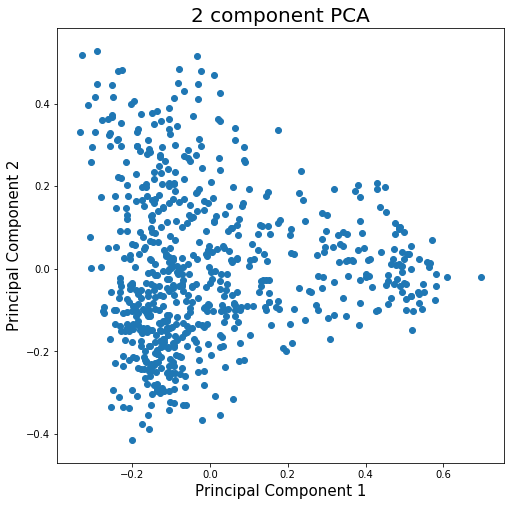

In [21]:
#plt.scatter(principalComponents[:,0], principalComponents[:,1])
#plt.show()


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax = plt.scatter(principalComponents[:,0], principalComponents[:,1])


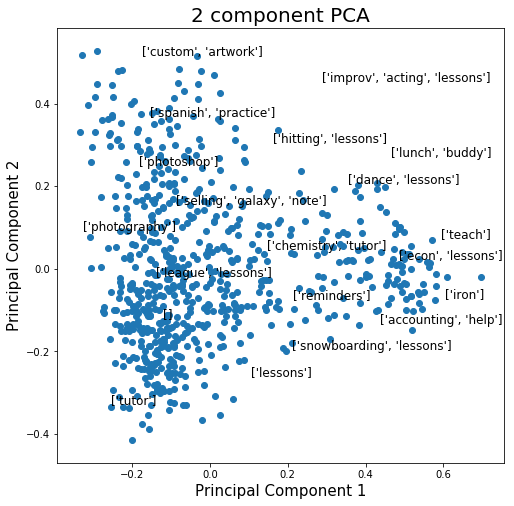

In [35]:
#plt.scatter(principalComponents[:,0], principalComponents[:,1])
#plt.show()


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax = plt.scatter(principalComponents[:,0], principalComponents[:,1])


sentence_titles = [] 
titles_for_plotting = list(np.arange(0, 400, 20))

#need to make sure we're plotting this correctly 
#then we want to append each word to a list of words
for title in titles_for_plotting: 
    sentence_titles.append(plt.text(principalComponents[title, 0], principalComponents[title, 1], filtered_word_list[title], fontsize = 12))

    adjust_text(sentence_titles, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2))  
    
#how do I add lines that lead to the words?

We then want to see the relationship between these 2 components by graphing them on a scatterplot. (https://seaborn.pydata.org/generated/seaborn.scatterplot.html). As we can see above, they now seem to have a positvely linear relationship, and a positive correlation. 

In [29]:
print(pca.explained_variance_ratio_)

[0.05978714 0.04133078]


Because PCA reduces the dimensionality of our data, we want to use the above code to determine how much variance we retain--from 300-d down to 2-D. For more information on explained variance, here's a helpful link https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff

#### (5) Data Visualization

One way to visualize these relationships is through t-SNE, which stands for t-Distributed Stochastic Neighbor Embedding. t-SNE is a techinique used fro dimensionality reduction, and that is useful when visualizing high-dimennsional datasets. (https://lvdmaaten.github.io/tsne/) 

According to the scikit-learn website, t-SNE is a tool "converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data." (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) The documentation also mentioned that it is very useful to incorporate another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) before using t-SNE if the number of features in our dataset is very high. Thus, earlier, to reduce features we used word embeddings and word averagings.

A really helpful article on the "hello, world" of t-SNE is the following: https://distill.pub/2016/misread-tsne/ They write, *"The goal is to take a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space, typically the 2D plane."*

An important feature of t-SNE is its perplexity, which is loosely defined as the hyperparameter that banaces out the local and global aspects of our title_vector dataset. The perpexlity can have a huge impact on the performance of t-SNE, which is why it is often useful to do multiple plots that use different perplexities, and then compare those results.

In [37]:
#testing out what shes doing here... recheck with jeremie
from sklearn.manifold import TSNE

#model initialization
tsne_50 = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 50)

Here we are using TSNE with n_components = 2, meaning that we have 2 dimensions of embedded space. The initialization of the embedding that we're using is 'random', which, according to this article (https://arxiv.org/abs/1711.09160), does not really have any significant difference in the results--given that "the variance is kept reasonably low." 

The perplexity that we used here is 50, which mean that this is the number of nearest neighbors used in multi-fold learning algorithms. We went with 50 because the official documentation suggested a value between 5 and 50 with larger datasets requiring larger perplexities.

In [38]:
# trasforming principal components
#tsne_df = tsne.fit_transform(word_vec_master)
tsne_df_50 = tsne_50.fit_transform(principalComponents)
#don't reallyy need to shorten the rows since we only have 671
tsne_df_50.shape

(671, 2)

Next, we want to transform the word vectors using t-SNE. We use the fit_transform function to fit our *word_vec_master* dataset into an embedded space and return that transformed output. We see that we have a 2-dimensional array with 671 entries.

Some helpful documentation that I used were the following:
- https://stackoverflow.com/questions/50198409/how-to-apply-t-sne-on-word2vec-model
- https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b t-SNE work on the MNIST dataset
- https://www.programcreek.com/python/example/101756/sklearn.manifold.TSNE
- https://colab.research.google.com/github/GokuMohandas/practicalAI/blob/master/notebooks/12_Embeddings.ipynb awesome content about word embeddings from one of my mentors 
- https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751 a great Medium post by another SharpestMinds mentee
- https://lvdmaaten.github.io/tsne/ 
- https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.array.html Arrays and Np.shape
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html


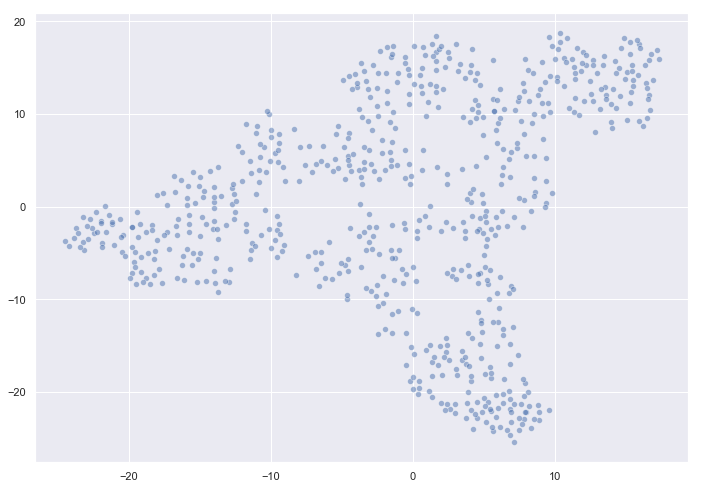

In [39]:
#using seaborn to visualize sentence relationships
sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
scatter50 = sns.scatterplot(tsne_df_50[:, 0], tsne_df_50[:, 1], alpha = 0.5)


Afterwards, we want to visualize the relationship (both linear and non-linear) between our sentence/title entries. To do this, we'll use a seaborn scatterplot. (https://seaborn.pydata.org/generated/seaborn.scatterplot.html) 

Because we have 2 resulting dimensions, we want to visualize them by creating a scatterplot of their relationship. Note that these dimensions are the title from our dataset (could be one word or one sentence) and their similarity score to the data in the Google News corpus. 

*check with jeremie if this is right *

In [43]:
#now we want to add labels to this, so use the package adjustText

#initialize the text box then create a loop that prints the 10th title

#sentence_titles_ = [] 
titles_for_plotting = list(np.arange(0, 400, 20))
#we are plotting the 50th title in the first 700 titles

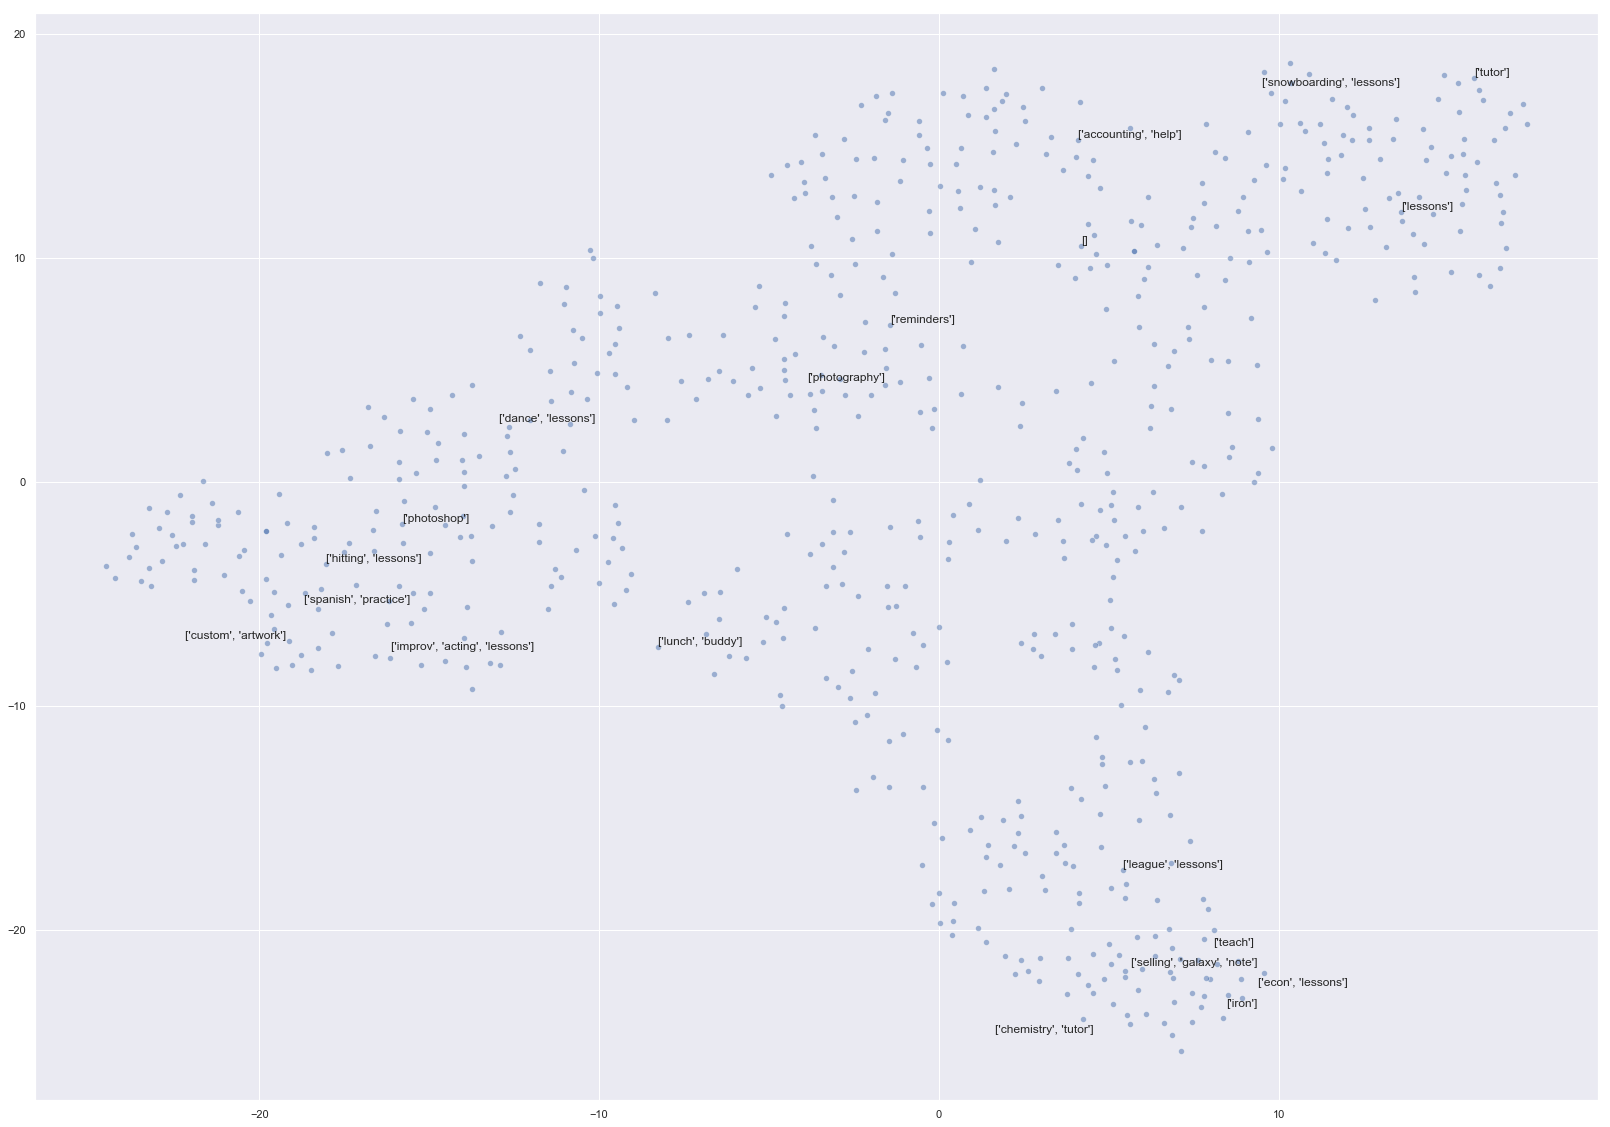

In [44]:
fig, ax = plt.subplots(figsize = (28, 20))
plot_50 = sns.scatterplot(tsne_df_50[:, 0], tsne_df_50[:, 1], alpha = 0.5)

#then we want to append each word to a list of words
for title in titles_for_plotting: 
    sentence_titles.append(plt.text(tsne_df_50[title, 0], tsne_df_50[title, 1], filtered_word_list[title], fontsize = 12))
    
#should i be doing the above on filtered word list or on the pca-completed list?

# we then want to plot these titles on the scatterplot
adjust_text(sentence_titles, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2))
            #arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

#what are the axes here?
# filtered_word_list[title] --> which list should i use here? i tried dict, then i tried master_vector_list

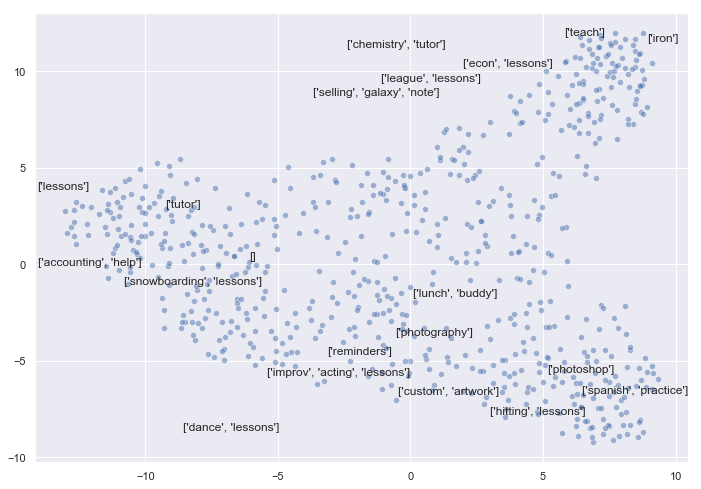

In [48]:
# tsne with perplexity 100 

#model initialization
tsne_100 = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

#model training
tsne_df_100 = tsne_100.fit_transform(principalComponents)
tsne_df_100.shape

#plotting sentence relationships
sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
scatter100 = sns.scatterplot(tsne_df_100[:, 0], 
                             tsne_df_100[:, 1], alpha = 0.5)


#fig, ax = plt.subplots(figsize = (28, 20))
#plot_100 = sns.scatterplot(tsne_df_100[:, 0], tsne_df_100[:, 1], alpha = 0.5)

titles_for_plotting_100 = list(np.arange(0, 400, 20))

for title in titles_for_plotting_100: 
    sentence_titles.append(plt.text(tsne_df_100[title, 0], tsne_df_100[title, 1], filtered_word_list[title], fontsize = 12))

adjust_text(sentence_titles, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2))
            #arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

#seems like the words are closer now... 


(671, 2)


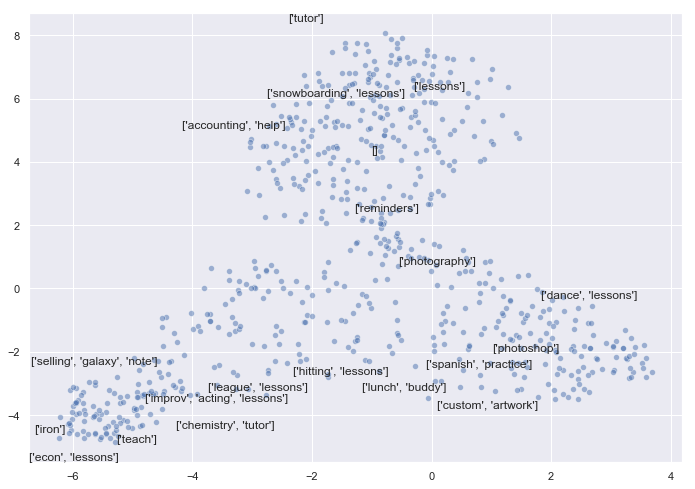

In [49]:
# tsne with perplexity 200

#model initialization
tsne_200 = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 200)

#model training
tsne_df_200 = tsne_200.fit_transform(principalComponents)
print(tsne_df_200.shape)

#plotting sentence relationships
sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
scatter200 = sns.scatterplot(tsne_df_200[:, 0], 
                             tsne_df_200[:, 1], alpha = 0.5)


#fig, ax = plt.subplots(figsize = (28, 20))
#plot_100 = sns.scatterplot(tsne_df_100[:, 0], tsne_df_100[:, 1], alpha = 0.5)

titles_for_plotting_200 = list(np.arange(0, 400, 20))

for title in titles_for_plotting_200: 
    sentence_titles.append(plt.text(tsne_df_200[title, 0], tsne_df_200[title, 1], filtered_word_list[title], fontsize = 12))

adjust_text(sentence_titles, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2))
            #arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

#seems like the words are farther?


(671, 2)


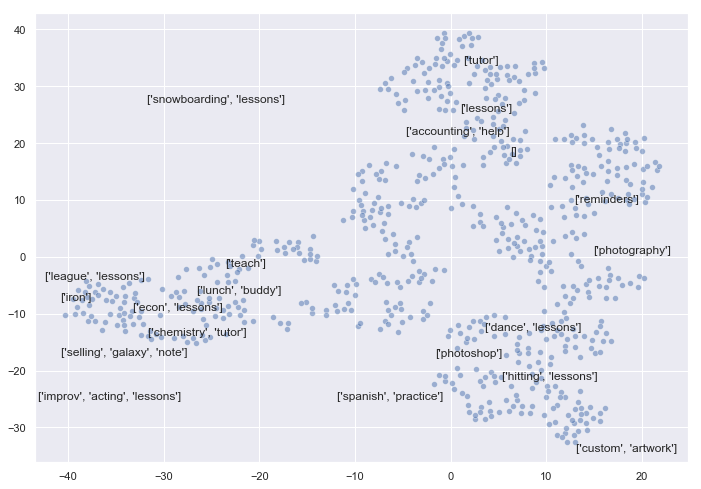

In [50]:
# tsne with perplexity 30

#model initialization
tsne_30 = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 30)

#model training
tsne_df_30 = tsne_30.fit_transform(principalComponents)
print(tsne_df_30.shape)

#plotting sentence relationships
sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
scatter30 = sns.scatterplot(tsne_df_30[:, 0], 
                             tsne_df_30[:, 1], alpha = 0.5)


#fig, ax = plt.subplots(figsize = (28, 20))
#plot_100 = sns.scatterplot(tsne_df_100[:, 0], tsne_df_100[:, 1], alpha = 0.5)

titles_for_plotting_30 = list(np.arange(0, 400, 20))

for title in titles_for_plotting_30: 
    sentence_titles.append(plt.text(tsne_df_30[title, 0], tsne_df_30[title, 1], filtered_word_list[title], fontsize = 12))

adjust_text(sentence_titles, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2))
            #arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

#seems like the words are closer now... 


****PSEUDOCODE 


def find_most_similar(input_doc_vec, docs_from_db_vec):
    input_doc_vec = vectorize_document(clean)
    docs_from_db_vec = vectorize_document(clean)
    #would these 2 be the same now? since we only have one dataset that hasn't been split into training/testing?
    docs_with_ranks = []
    for db_doc_vec in docs_from_db_vec: 
        similarity = np.dot(input_doc_vec, db_doc_vec)
        docs_with_ranks += [(similarity, docs_db_vec)] 
    return sort_by_similarity(docs_with_ranks)


def process_new_document(document): 
    ```document: a raw document that the user provides```
        cleaned_document = clean_raw_document(document)
        vectorized_document = vectorize_document(cleaned_document)
        docs_from_db_vec = load_from_db(filepath_to_csv_or_db)
        save(vectorized_document, filepath_to_csv_or_db) <- might be a bit more complicated, since you’ll want to save it into a table along with the other document vectors that your users have input earlier, along with an index of some kind that lets you look the vector up
        sorted_documents = find_most_similar(vectorized_document, docs_from_db_vec)

    return sorted_documents
